In [1]:
# additional imports of python modules
# python module imports needed in customized functions:
import numpy as np
import tensorflow as tf
import sys

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import time
import pandas as pd
#tf.set_random_seed(1)
#np.random.seed(1)
import sys
tf.__version__, sys.version_info



('1.4.0',
 sys.version_info(major=3, minor=6, micro=3, releaselevel='final', serial=0))

In [2]:
import keras
from keras.utils import np_utils
from keras import backend as K
from keras import metrics


Using TensorFlow backend.


# Import data from keras

In [3]:
from keras.datasets import mnist
#import numpy as np
(x_train, y_train), (x_test, y_test_num) = mnist.load_data()

We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.

In [4]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test_num, 10)

(60000, 784)
(10000, 784)


# Ladder network


In [5]:
from keras.layers import Input, Dense, GaussianNoise, BatchNormalization, Activation, Layer
from keras.models import Model

# this is the size of our encoded representations
stddev = 0.05

In [6]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

## custom normalization layer
Define a layer that performs normalization (=standardization) of a layer using the mean and the var of the inputs to the layer
The normalization is required before acting with relu:

from https://theneuralperspective.com/2016/10/27/gradient-topics/:

There are several types of normalization techniques but the idea behind all of them is the same, which is shifting our inputs to a zero mean and unit variance. We normalize the inputs before applying the non-linearity. We do this because we do not want the inputs to saturate the non-linearities at the extremes. (Checkout SNNs/SELU for some recent updates on this subject).

Remark about the difference from batch norm:  Batch normalization is very nice but it is based on minibatch size and so it’s a bit difficult to use with recurrent architectures. With layer normalization, we instead compute the mean and variance using ALL of the summed inputs to the neurons in a layer for EVERY single training case. This removes the dependency on a minibatch size. Unlike batch normalization, the normalization operation for layer norm is same for training and inference. More details can be found on Hinton’s paper here.

In [7]:
class CustomLayer_Normalization(Layer):
    """Apply layer normalization.
       shifting our inputs to a zero mean and unit variance. 
       We normalize the inputs before applying the non-linearity. 
       We do this because we do not want the inputs to saturate the non-linearities at the extremes. 
       (Checkout SNNs/SELU for some recent updates on this subject).
       
       no need for build -- no trainable weights. 
        # Arguments
            epsilon: regularizer for zero division
        # Input shape
            Arbitrary. Use the keyword argument `input_shape`
            (tuple of integers, does not include the samples axis)
            when using this layer as the first layer in a model.
        # Output shape
            Same shape as input.
    """
    def __init__(self, epsilon = 1e-6, **kwargs):
        super(CustomLayer_Normalization, self).__init__(**kwargs)
        self.epsilon = epsilon
        
    def call(self, inputs):
        return (inputs - K.mean(inputs,axis=-1,keepdims=True))/(K.std(inputs,axis=-1,keepdims=True)+self.epsilon) # change axis for conv2D
        # keepdims=True is important to keep the original dimension
        #return inputs #- K.mean(inputs,axis=-1,keepdims=True))
        
    def compute_output_shape(self, input_shape):
        return input_shape
    


In [8]:
def build_encoder_layer(encoding_dim_,layer_id,stddev_=0.05):
    """
    Create the layers
    
    Parameters
    ==========
    
    encoding_dim_:int
        number of perceptons 
    layer_id: string
        part of the name
    stddev: double
        standard deviation of the Gaussion noise layer
        
    Returns
    =======
    
    x,y: I don't know what this is
    
    """
    sublayers={}
    s_id = 'encoder_' + layer_id + '/'
    sublayers['lin_trans'] = Dense(encoding_dim_,activation = None,name=s_id + 'lt')
    sublayers['norm'] = CustomLayer_Normalization(name=s_id + 'norm')
    sublayers['noise_add'] = GaussianNoise(stddev_,name=s_id + 'noise')
    sublayers['batch_norm'] = BatchNormalization(name=s_id + 'bn')
    sublayers['activation'] = Activation('relu',name=s_id + 'output')
    return sublayers

def build_decoder_layer(decoding_dim_,layer_id,activation_name):
    sublayers={}
    s_id = 'decoder' + layer_id + '/'
    sublayers['lin_trans']  = Dense(decoding_dim_,activation = None,name = s_id + 'lt')
    sublayers['norm'] = CustomLayer_Normalization(name=s_id + 'norm')
    sublayers['activation'] = Activation(activation_name,name=s_id + 'output')
    return sublayers

In [9]:
def link_sublayer_corr_encoder(x,sublayers):
    """
    Link the sublayers for the autoencoder
    
    Parameters
    ==========
    x: input for the first sublayer
    
    sublayers: dict containing the sublayers
    
    """
    try:
        x=sublayers['lin_trans'](x)
        x=sublayers['norm'](x)
        y=sublayers['noise_add'](x)
        x=sublayers['batch_norm'](y)
        x=sublayers['activation'](x)
    except:
        print("Something failed")
    return x,y

def link_sublayer_clean_encoder(x,sublayers):
    """
    Link the sublayers for the supervised approach
    
    Parameters
    ==========
    x: input for the first sublayer
    
    sublayers: dict containing the sublayers
    
    """
    try:
        x=sublayers['lin_trans'](x)
        y=sublayers['norm'](x)
        x=sublayers['batch_norm'](y)
        x=sublayers['activation'](x)
    except:
        print("Something failed")
    return x,y

def link_sublayer_decoder(x,sublayers):
    """
    Link the sublayers 
    
    Parameters
    ==========
    x: input for the first sublayer
    
    sublayers: dict containing the sublayers
    
    """
    try:
        x=sublayers['lin_trans'](x)
        x=sublayers['norm'](x)
        x=sublayers['activation'](x)
    except:
        print("Something failed")
    return x

In [10]:
Layer_dim = [784,128,32]

## Create the clean and corrupted encoders
##########################################
# Input layer
input_img = Input(shape=(Layer_dim[0],),name = 'input_img')
# Build encoder sublayers: generic for clean and noisy encoder
encoder_layers = {}
encoder_layers['1'] = build_encoder_layer(Layer_dim[1],'1')
encoder_layers['2'] = build_encoder_layer(Layer_dim[2],'2')
# NOTE:  Building the encoder layers only once but linking them twice ensures that the same weights are used by the AE and the clean encoder
# Corrupt input and link noisy encoder (for DAE)
corrupted_img  = GaussianNoise(stddev,name="corrupt_img")(input_img)
encoded_corr_1,sidepath_ae_1 = link_sublayer_corr_encoder(corrupted_img,encoder_layers['1'])
encoded_corr_2,sidepath_ae_2 = link_sublayer_corr_encoder(encoded_corr_1,encoder_layers['2'])

# Link the clean encoder (for supervised channel)
encoded_clean_1,sidepath_sv_1 = link_sublayer_clean_encoder(input_img,encoder_layers['1'])
encoded_clean_2,sidepath_sv_2 = link_sublayer_clean_encoder(encoded_clean_1,encoder_layers['2'])

# channel the clean encoder output into the classifier
predicted_labels = Dense(10,activation='sigmoid',name='predictor')(encoded_clean_2)

## Create the decoder
##########################################
# Build a decoder
decoder_layers = {}
decoder_layers['0'] = build_decoder_layer(Layer_dim[0],'0',activation_name = 'sigmoid')
decoder_layers['1'] = build_decoder_layer(Layer_dim[1],'1',activation_name = 'sigmoid')
#decoder_layers['0'] = Dense(Layer_dim[0], activation='sigmoid',name='decoded_image')
#decoder_layers['1'] = Dense(Layer_dim[1], activation='sigmoid',name='decoded_1')
# link the decoder to the corrupted encoder
decoded_1 = link_sublayer_decoder(encoded_corr_2,decoder_layers['1'])
decoded   = link_sublayer_decoder(decoded_1,decoder_layers['0'])
#decoded_1 = decoder_layers['1'](encoded_corr_2)
#decoded   = decoder_layers['0'](decoded_1)

#decoded = CustomLayer_Normalization()(decoded)


# Defining a custom layer for the recon-loss
The goal of the custom layer is to enable the addition of a loss function that depends not only on the model outputs but also on intermediate layers' outputs. For the ladder network these would be the reconstruction losses, which depend on the decoder and clean encoder layers. 

In [11]:
# reconstruction loss weights
w_rl = [1.0, 1.0]

class CustomLayer_ReconLoss(Layer):
    def __init__(self, **kwargs):
        # class constructor
        self.is_placeholder = True
        self.output_dim = 10
        super(CustomLayer_ReconLoss, self).__init__(**kwargs)
        
    def reconstruction_loss(self, z_enc_inp,z_dec_0, z_enc_1, z_dec_1):
        # add all reconstruction losses weighted by recon_weights
        # note: the binary_crossentropy metric does not automatically average over the batch, 
        # this is done here by K.mean
        
        return w_rl[0]*K.mean(metrics.binary_crossentropy(z_enc_inp,z_dec_0))
        #return w_rl[0]*K.mean(metrics.binary_crossentropy(z_enc_inp,z_dec_0)) + w_rl[1]*K.mean(metrics.binary_crossentropy(z_enc_1, z_dec_1))
                
    def call(self, inputs):
        # inputs is a list of layers needed for the calculation of the reconstruction loss
        # returns: predicted_labels, needed in order to calculate the supervised loss later on. 
        predicted_label = inputs[0]   # predicted labels by clean encoder:  the return variable of the call
        input_img       = inputs[1]   # original images, dim = 784
        decoded         = inputs[2]   # decoded images of AE, dim = 784
        encoded_clean_1 = inputs[3]   # dim = 128
        decoded_1       = inputs[4]   # dim = 128
        loss = self.reconstruction_loss(input_img,decoded,encoded_clean_1,decoded_1)
        self.add_loss(loss, inputs=inputs) # here better to define only the required inputs as inputs
        return predicted_labels
    
    def compute_output_shape(self, input_shape):
        return input_shape[0]
    
# when calling the CustomLayer_ReconLoss, the returned value of "call(self, inputs)" is returned. 
y = CustomLayer_ReconLoss()([predicted_labels,input_img,decoded,encoded_clean_1,decoded_1])

# Constructing the model
Construct a model with input_img as the input and y (the custom layer) as an output. This enables us to define a custom loss function and also to return the value y which are the predicted labels transferred to the model using the custom layer. 

In [12]:
ladder_custom = Model(input_img,y)

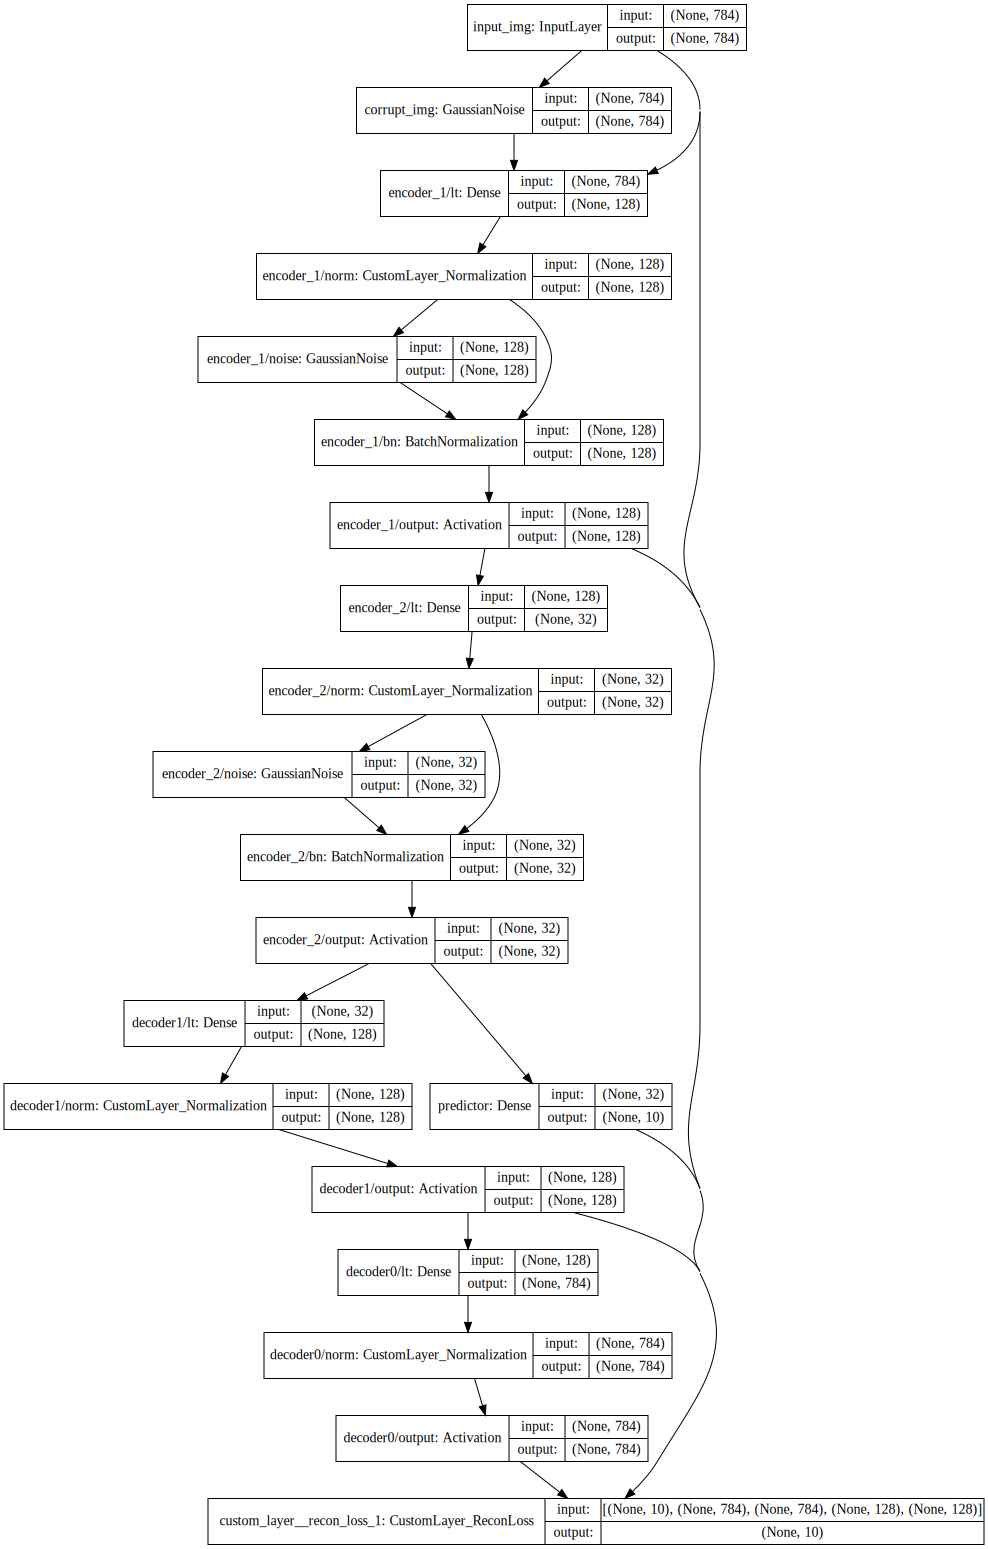

In [13]:
#ladder_custom.summary()
SVG(model_to_dot(ladder_custom,show_shapes=True).create(prog='dot',format='svg'))

In [14]:
ladder_custom.compile(optimizer='adadelta', loss='categorical_crossentropy')

In [15]:
ladder_custom.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          (None, 784)          0                                            
__________________________________________________________________________________________________
corrupt_img (GaussianNoise)     (None, 784)          0           input_img[0][0]                  
__________________________________________________________________________________________________
encoder_1/lt (Dense)            (None, 128)          100480      corrupt_img[0][0]                
                                                                 input_img[0][0]                  
__________________________________________________________________________________________________
encoder_1/norm (CustomLayer_Nor (None, 128)          0           encoder_1/lt[0][0]               
          

In [16]:
infoLadder=ladder_custom.fit(x_train,y_train,
                epochs=10,
                batch_size=100,
                shuffle=True,
                validation_data=(x_test,y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 11s 177us/step - loss: 0.7189 - val_loss: 0.4007
Epoch 2/10
60000/60000 [==============================] - 10s 172us/step - loss: 0.3661 - val_loss: 0.3451
Epoch 3/10
60000/60000 [==============================] - 10s 170us/step - loss: 0.3262 - val_loss: 0.3311
Epoch 4/10
60000/60000 [==============================] - 11s 182us/step - loss: 0.3002 - val_loss: 0.3201
Epoch 5/10
60000/60000 [==============================] - 11s 176us/step - loss: 0.2806 - val_loss: 0.3176
Epoch 6/10
60000/60000 [==============================] - 11s 180us/step - loss: 0.2666 - val_loss: 0.2960
Epoch 7/10
60000/60000 [==============================] - 11s 182us/step - loss: 0.2548 - val_loss: 0.2924
Epoch 8/10
60000/60000 [==============================] - 11s 185us/step - loss: 0.2456 - val_loss: 0.2861
Epoch 9/10
60000/60000 [==============================] - 11s 190us/step - loss: 0.2381 - val_

# Predicting and plotting

## encode and decode some digits


A layer is an object which has a well defined number of outputs. The input is not specified upon definition of the layer, but only upon "linking", i.e when the layer received a specific input. Only after linking, the weight tensor is defined and can then be trained. 

### predicting
After training the network we obtain a set of linked layers that already contain the trained weights. For example, "decoded" stands for the output of the autoencoder which is linked to the input input_img, via a set of specific weights. We can now construct a new model that uses the weights for prediction. 

After constructing the model we can perform a prediction giving it x_test as an input, and obtaining the decoded image as an output. 


In [17]:
ladder_for_prediction = Model(input_img,[decoded,predicted_labels])


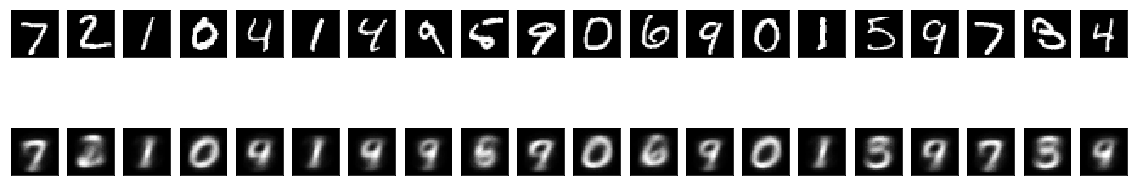

predicted digit: 7 true label: 7
predicted digit: 2 true label: 2
predicted digit: 1 true label: 1
predicted digit: 0 true label: 0
predicted digit: 4 true label: 4
predicted digit: 1 true label: 1
predicted digit: 4 true label: 4
predicted digit: 9 true label: 9
predicted digit: 5 true label: 5
predicted digit: 9 true label: 9
predicted digit: 0 true label: 0
predicted digit: 6 true label: 6
predicted digit: 9 true label: 9
predicted digit: 0 true label: 0
predicted digit: 1 true label: 1
predicted digit: 5 true label: 5
predicted digit: 9 true label: 9
predicted digit: 7 true label: 7
predicted digit: 3 true label: 3
predicted digit: 4 true label: 4


In [19]:
[decoded_imgs,encoder_output] = ladder_for_prediction.predict(x_test)
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt




n = 20  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    
plt.show()
for i in range(n):
    print('predicted digit:',np.argmax(encoder_output[i]),'true label:',y_test_num[i])

In [20]:
np.mean(np.std(decoded_imgs,axis=1)),np.mean(np.std(x_test,axis=1))

(0.19458869, 0.30366075)

In [21]:
np.mean(np.argmax(encoder_output,axis=1)==y_test_num)*100

97.899999999999991